# Ice and snow thickness

- M,A,M and spring mean
- On day of phototrophy onset and half PAr limintation

## Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import palettable.cmocean.sequential as cmOcSeq
import palettable.cmocean.diverging as cmOcDiv
import seaborn as sns

from datetime import datetime, timedelta

from glob import glob 

import utilsRegions as urgn
import utilsGen as utl
import mapPlots as mplt
import diagnostics as dgnst
import utlshistograms as uhist

%load_ext autoreload
%autoreload 2

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8188',n_workers=16, threads_per_worker=1)
client = Client(cluster)

http://127.0.0.1:8188/status

In [50]:
cluster.close()
client.close()

In [2]:
scenarios = ['historical-DFS-G510.00','RCP85-G510.14-G515.00-01']
hist,rcp85 = scenarios
periods = ['1981-2000','2023-2042','2066-2085']
past,pres,futur=periods
runs={past:hist, pres:rcp85, futur:rcp85}
timeperiod = {past: slice('1981','2000'), pres:slice('2023','2042'), futur: slice('2066','2085') }

dadic={}
datadir = '/tsanta/ahaddon/data/'
utl.loadNAAmesh(dadic)

### Load model output

In [ ]:
for scn in scenarios:
    dadic[scn+'biolog'] = xr.open_mfdataset(datadir+scn+'/NAA_1d_*_biolog.nc', combine='by_coords', parallel=True,chunks={'time_counter':365,'x':100,'y':100})
    dadic[scn+'diad'] = xr.open_mfdataset(datadir+scn+'/NAA_730h_*_diad_T.nc', combine='by_coords', parallel=True)

In [5]:
dadic[scn+'biolog']

<xarray.Dataset>
Dimensions:            (time_counter: 25550, y: 400, x: 568, deptht: 46,
                        tbnds: 2)
Coordinates:
  * deptht             (deptht) float32 0.5487 1.973 ... 5.622e+03 5.878e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time_counter       (time_counter) object 2016-01-01 12:00:00 ... 2085-12-...
Dimensions without coordinates: y, x, tbnds
Data variables: (12/19)
    Cflx               (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    Delc               (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    Kg                 (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    SSS                (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    SST                (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    fstricgca          (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    ...                 ...
    pCO2_atm           (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    pCO2_sw            (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    sfcocedms          (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    sfcoceno3          (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    sfcocepar          (time_counter, y, x) float32 dask.array<chunksize=(365, 100, 100), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) object dask.array<chunksize=(365, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.1
    production:   An IPSL model
    TimeStamp:    23/12/2020 00:39:33 -0500
    file_name:    NAA_1d_20160101_20161231_biolog.nc
    history:      Wed Dec 23 05:34:27 2020: ncks -4 -L 1 -O NAA_1d_20160101_2...
    NCO:          4.6.6

### Load diagnostics

In [3]:
processDataDir = '/tsanta/ahaddon/NAA/processedData/'
# processDataDir = '/home/ahaddon/Work/NAA/processedData/'
# varsave = ['icedia','ileadfra2','fstric','iceno3','icenh4','icedia','limN','limpar']#,'iicethic','isnowthi''iceGPPfall'
varsave = ['iicethic','isnowthi']
clim={}
for per in periods: 
    scn=runs[per] 
    for var in varsave:
        clim[per+var] = xr.open_dataarray(f'{processDataDir}{scn}/panArctic/{var}_20yclim{per}_1d.nc')

In [4]:
climdiag={}
for per in periods:
    scn=runs[per] 
    climdiag[per] = xr.open_dataset(f'{processDataDir}{scn}/panArctic/IAdiagnostics_20yclim{per}.nc').compute()
climdiag[periods[0]]

<xarray.Dataset>
Dimensions:                 (y: 400, x: 568)
Coordinates:
    nav_lat                 (y, x) float32 53.41 53.48 53.56 ... 44.23 44.11
    nav_lon                 (y, x) float32 -132.6 -132.5 -132.4 ... 15.75 15.66
Dimensions without coordinates: y, x
Data variables: (12/22)
    doyNlim5                (y, x) float64 nan nan nan nan ... nan nan nan nan
    doyPARlim15             (y, x) float64 nan nan nan nan ... nan nan nan nan
    doyPARlim5              (y, x) float64 nan nan nan nan ... nan nan nan nan
    doySIbreak              (y, x) float64 nan nan nan nan ... nan nan nan nan
    doyPARlimGTnlim         (y, x) float64 nan nan nan nan ... nan nan nan nan
    least_lim               (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                      ...
    least_lim_nyears        (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    nonLimGwth_nyears       (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    lengthPAR_nyears        (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    doyIApeak_nyears        (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    doySIfreezeUp_nyears    (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    doyIAstd_nyears         (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

### Plot setup

In [16]:
ltr=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
# plt.rcParams.update({'font.size': 9})

def pltClim(varclim,title,unit,
            article=False,ltr=ltr, **pltkw ):

    if article: fig,ax = mplt.initmaps(1,3,figsize=(18/2.54,8/2.54),rnd=True,extent=[-180,180, 62,90])
    else: fig,ax = mplt.initmaps(1,3,figsize=(15,6),rnd=True,extent=[-180,180, 62,90])

    fig.suptitle(title, fontsize=10)
    fig.tight_layout()
    if article: fig.subplots_adjust(hspace=0.02,wspace=0.02,top=0.93)
    
    for i,per in enumerate(periods):
        f,a,pl=mplt.singleMap(varclim[per], 
                            dadic, fig=fig,ax=ax[i], cbar=False, 
                            title=None, 
                            **pltkw
                            )
        ax[i].set_title(per, fontsize=8)

    for il,a in enumerate(fig.axes): a.text(0.05,0.9,f'({ltr[il]})',transform=a.transAxes)

    cbar_ax = fig.add_axes([0.5-0.15, 0.08, 0.3, 0.03])                               
    cl = fig.colorbar(pl,cax=cbar_ax, extend='max', orientation='horizontal', shrink=0.5)
    cl.set_label(unit, fontsize=8)
    cl.ax.tick_params(labelsize=8)


In [6]:


def pltClimdiff(varclim,title,unit,
                article=False,ltr=ltr, diffpltkw={} ):
    
    if article: fig,ax = mplt.initmaps(1,3,figsize=(18/2.54,8/2.54),rnd=True,extent=[-180,180, 62,90])
    else: fig,ax = mplt.initmaps(1,3,figsize=(15,6),rnd=True,extent=[-180,180, 62,90])

    fig.suptitle(title,fontsize=10)
    fig.tight_layout()
    if article:fig.subplots_adjust(hspace=0.35,wspace=-0.1,top=0.93)

    for i in [1,2]:
        f,a,pl=mplt.singleMap(varclim[periods[i]] - varclim[past], 
                              dadic, fig=fig,ax=ax[(i-1)*2],  
                              title=None, cbar=False, 
                              **diffpltkw,
                                   )
        ax[(i-1)*2].set_title(f'Change [{periods[i]}] - [{past}]', fontsize=8)

    f,a,pl=mplt.singleMap(varclim[futur] - varclim[pres], dadic, fig=fig,ax=ax[1],  
                          title=None, cbar=False, 
                          **diffpltkw,
                               )
    ax[1].set_title(f'Change [{futur}] - [{pres}]', fontsize=8)

    cbar_ax = fig.add_axes([0.5-0.15, 0., 0.3, 0.03])                               
    cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.4)
    cl.set_label(unit)
    
    
    
def pltClim_withdiff(varclim,title,unit,
                     article=False,ltr=ltr, mainpltkw={}, diffpltkw={} ):
    
    if article: fig,ax = mplt.initmaps(2,3,figsize=(18/2.54,14/2.54),rnd=True,extent=[-180,180, 62,90])
    else: fig,ax = mplt.initmaps(2,3,figsize=(18,14),rnd=True,extent=[-180,180, 62,90])

    fig.suptitle(title,fontsize=10)
    fig.tight_layout()
    if article:fig.subplots_adjust(hspace=0.02,wspace=0.02,top=0.93)

    for i,per in enumerate(periods):
        f,a,pl=mplt.singleMap(varclim[per], 
                            dadic, fig=fig,ax=ax[0,i], cbar=False, 
                            title=None, 
                            **mainpltkw
                            )
        a.set_title(per, fontsize=8)
            
    cbar_ax = fig.add_axes([0.5-0.15, 0.5+0.015, 0.3, 0.015])                               
    cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.4)
    cl.set_label(unit)

    # leg = cbar_ax.legend(loc='lower center', bbox_to_anchor=(1.7, -4), handlelength=4, frameon=False,
    #     handles=[mpatches.Patch(facecolor='w',hatch=r'xxx',label='Diagnostic definition\nsatisfied for less\nthan 10 years')])
    # leg.get_patches()[0].set_height(15)
    # leg.get_patches()[0].set_y(-4)


    for i in [1,2]:
        f,a,pl=mplt.singleMap(varclim[periods[i]] - varclim[past], 
                              dadic, fig=fig,ax=ax[1,(i-1)*2],  
                              title=None, cbar=False, 
                              **diffpltkw,
                                   )
        ax[1,(i-1)*2].set_title(f'Change [{periods[i]}] - [{past}]', fontsize=8)

    f,a,pl=mplt.singleMap(varclim[futur] - varclim[pres], dadic, fig=fig,ax=ax[1,1],  
                          title=None, cbar=False, 
                          **diffpltkw,
                               )
    ax[1,1].set_title(f'Change [{futur}] - [{pres}]', fontsize=8)

    cbar_ax = fig.add_axes([0.5-0.15, 0.0, 0.3, 0.015])                               
    cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.4)
    cl.set_label(unit)

## Ice and snow thickness plots


### at Phototrophy onset

In [7]:
for i,per in enumerate(periods):
    clim[per+'iicethic-photo'] = clim[per+'iicethic'].where(climdiag[per]['doyPARlim15']>=1).sel(dayofyear=climdiag[per]['doyPARlim15'].fillna(1).astype(int) )
    clim[per+'isnowthi-photo'] = clim[per+'isnowthi'].where(climdiag[per]['doyPARlim15']>=1).sel(dayofyear=climdiag[per]['doyPARlim15'].fillna(1).astype(int) )

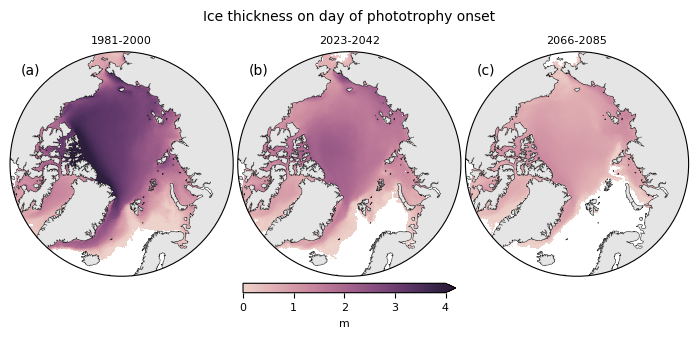

In [17]:
pltClim({per:clim[per+'iicethic-photo'] for per in periods},'Ice thickness on day of phototrophy onset','m',
        article=True,
        vmin=0, vmax=4, cmap=sns.cubehelix_palette(as_cmap=True), extend='max')

plt.savefig('../figs/IAphenology23/icethick-photo-300dpi.png',bbox_inches='tight',dpi=300)
plt.savefig('../figs/IAphenology23/icethick-photo-90dpi.png',bbox_inches='tight',dpi=90)

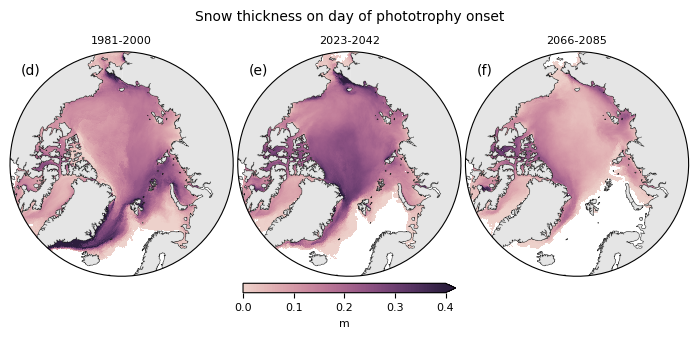

In [18]:

pltClim({per:clim[per+'isnowthi-photo'] for per in periods},'Snow thickness on day of phototrophy onset','m',
        article=True, ltr=ltr[3:],
        vmin=0, vmax=.4, cmap=sns.cubehelix_palette(as_cmap=True), extend='max')

plt.savefig('../figs/IAphenology23/snthick-photo-300dpi.png',bbox_inches='tight',dpi=300)
plt.savefig('../figs/IAphenology23/snthick-photo-90dpi.png',bbox_inches='tight',dpi=90)

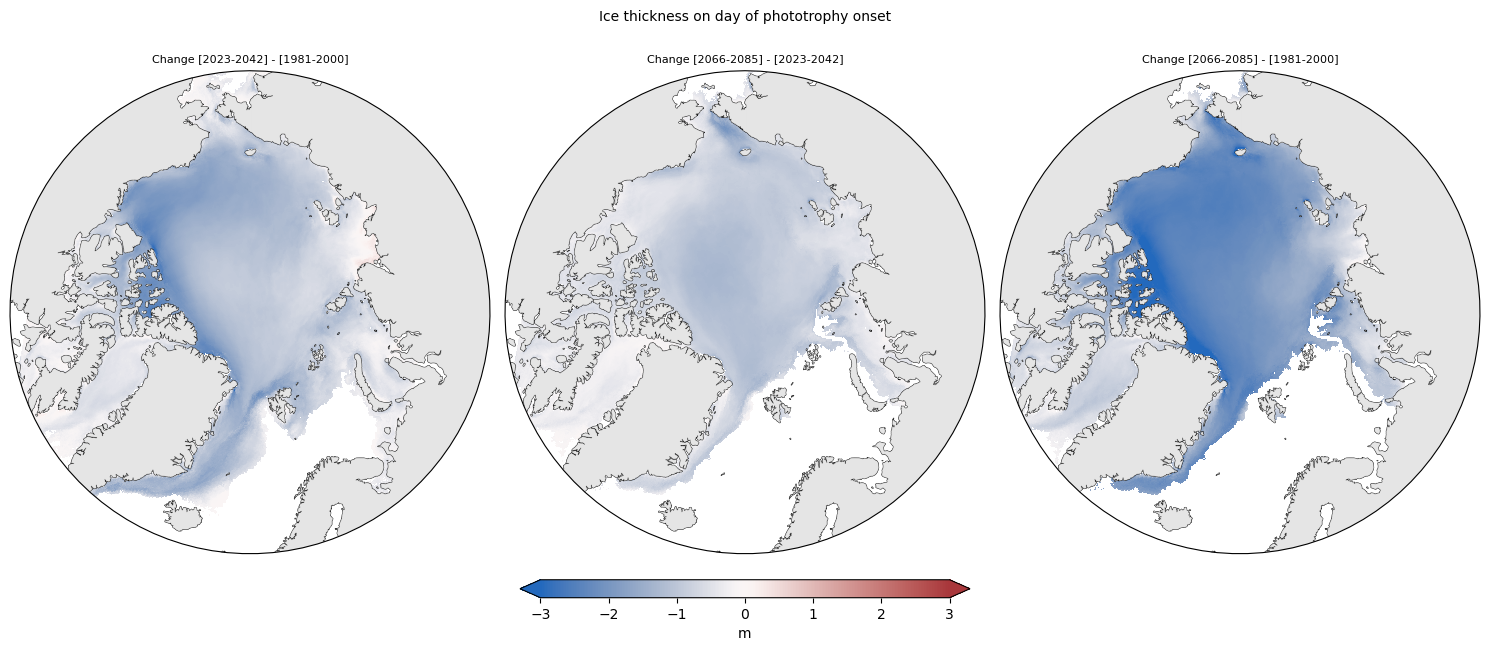

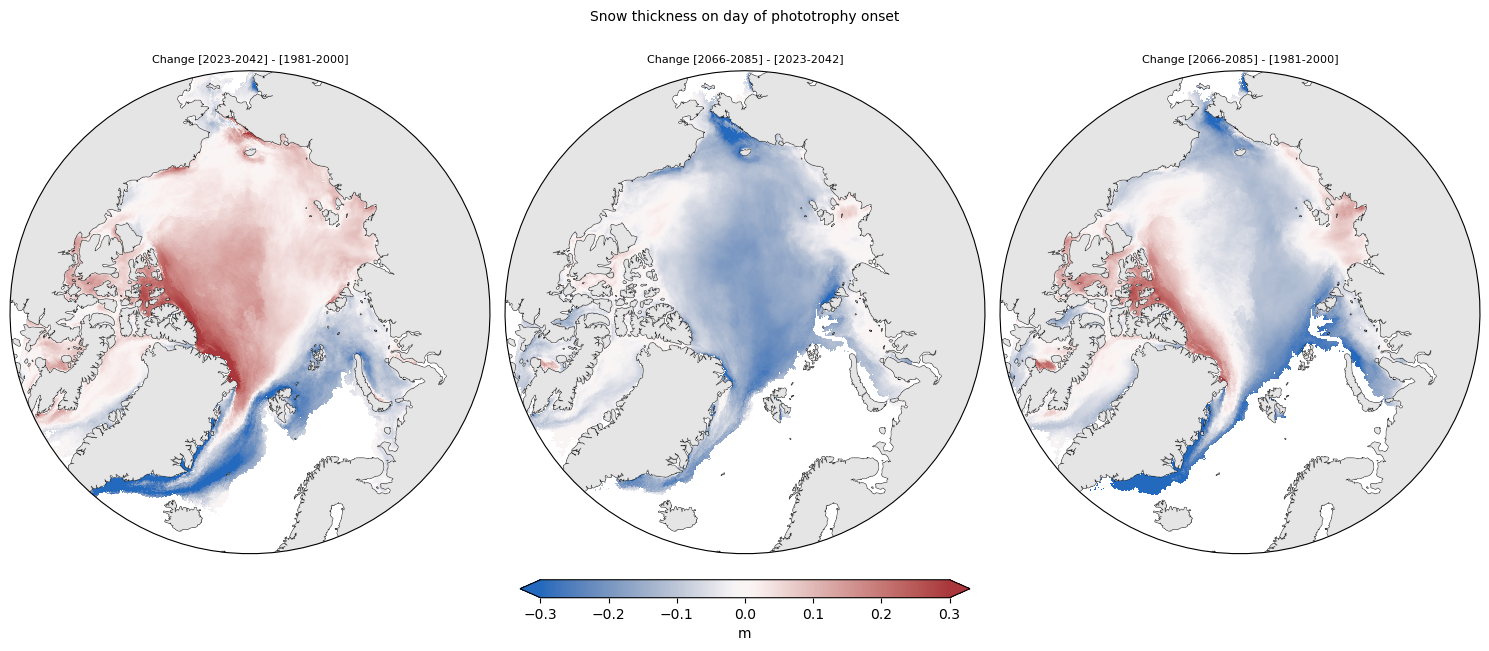

In [49]:
pltClimdiff({per:clim[per+'iicethic-photo'] for per in periods},'Ice thickness on day of phototrophy onset','m',
                 diffpltkw={'vmin':-3, 'vmax':3, 'cmap':'vlag'},
)
pltClimdiff({per:clim[per+'isnowthi-photo'] for per in periods},'Snow thickness on day of phototrophy onset','m',
                 diffpltkw={'vmin':-.3, 'vmax':.3, 'cmap':'vlag'},
)
            

# plt.savefig('../figs/IAphenology23/-300dpi.png',bbox_inches='tight',dpi=300)
# plt.savefig('../figs/IAphenology23/-90dpi.png',bbox_inches='tight',dpi=90)

What controls photophrophy onset?

Recent past
- Dominant : Thin snow but thick ice on day of photo, areas where photo is late, need to wait for snow to melt, north of CAA, central arctic, Beaufort and E. Siberia Seas
- Thin snow and thin ice : early photo, Laptev, Baffin, low lats CAA
- Thick snow but thin ice : MIZ? Barents and Kara seas.
- Thick snow and thick ice : late photo due to increase in incoming shortwave radiation
  
Near Future
 - Impact of loss of ice thickness dominant in large part of the Arctic
    - Phototrophy subtantially earlier where ice is thinner but little change to snow : Beaufort, Chukchi and to a lesser extent E. Sib
    - Increase of snow on day of photo is the impact of thinner ice so do not need to wait for snow to melt : north of CAA, central Arctic
- Laptev and low lats of CAA : little change in ice but thicker snow, slightly later phototrophy
- Areas with little change : Baffin, to a lesser extent Bering
- GIN, Barents, Kara : loss of both, much earlier

Late century from near future
- Decrease of both almost everywhere, but loss of ice thickness less than during transition from recent past to near future
- Laptev, Beaufort and low lats of CAA : little change in ice and snow and photo
- Gulf of Boothia only spot in CAA with loss of snow
- LIA : little change in snow, loss of ice
- Central Arctic, Chukchi, E. Siberia : loss of snow 

Late century from recent past
- Laptev and low lats of CAA : thicker snow compensates for little loss of ice so slightly later phototrophy
- central arctic, Beaufort, Chukchi, E. Sib : substantial loss of ice, little change to increase of snow, do not need to wait for snow to melt
- Baffin little change


### at half PAR lim

In [21]:
for i,per in enumerate(periods):
    clim[per+'iicethic-halfPAR'] = clim[per+'iicethic'].where(climdiag[per]['doyPARlim5']>=1).sel(dayofyear=climdiag[per]['doyPARlim5'].fillna(1).astype(int) )
    clim[per+'isnowthi-halfPAR'] = clim[per+'isnowthi'].where(climdiag[per]['doyPARlim5']>=1).sel(dayofyear=climdiag[per]['doyPARlim5'].fillna(1).astype(int) )

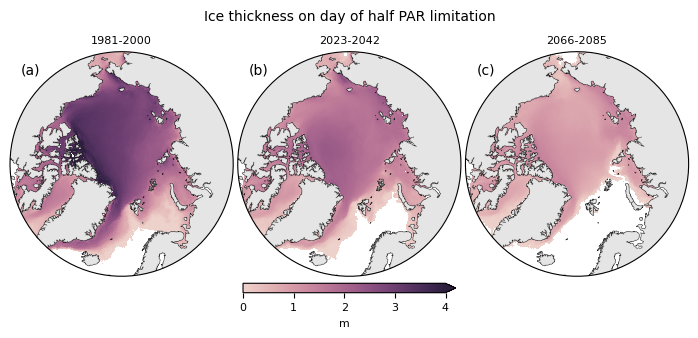

In [22]:
pltClim({per:clim[per+'iicethic-halfPAR'] for per in periods},'Ice thickness on day of half PAR limitation','m',
        article=True,
        vmin=0, vmax=4, cmap=sns.cubehelix_palette(as_cmap=True), extend='max')

plt.savefig('../figs/IAphenology23/icethick-halfPAR-300dpi.png',bbox_inches='tight',dpi=300)
plt.savefig('../figs/IAphenology23/icethick-halfPAR-90dpi.png',bbox_inches='tight',dpi=90)

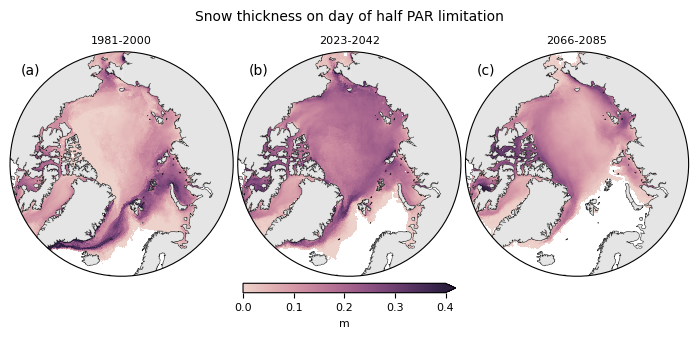

In [23]:

pltClim({per:clim[per+'isnowthi-halfPAR'] for per in periods},'Snow thickness on day of half PAR limitation','m',
        article=True,
        vmin=0, vmax=.4, cmap=sns.cubehelix_palette(as_cmap=True), extend='max')

plt.savefig('../figs/IAphenology23/snthick-halfPAR-300dpi.png',bbox_inches='tight',dpi=300)
plt.savefig('../figs/IAphenology23/snthick-halfPAR-90dpi.png',bbox_inches='tight',dpi=90)

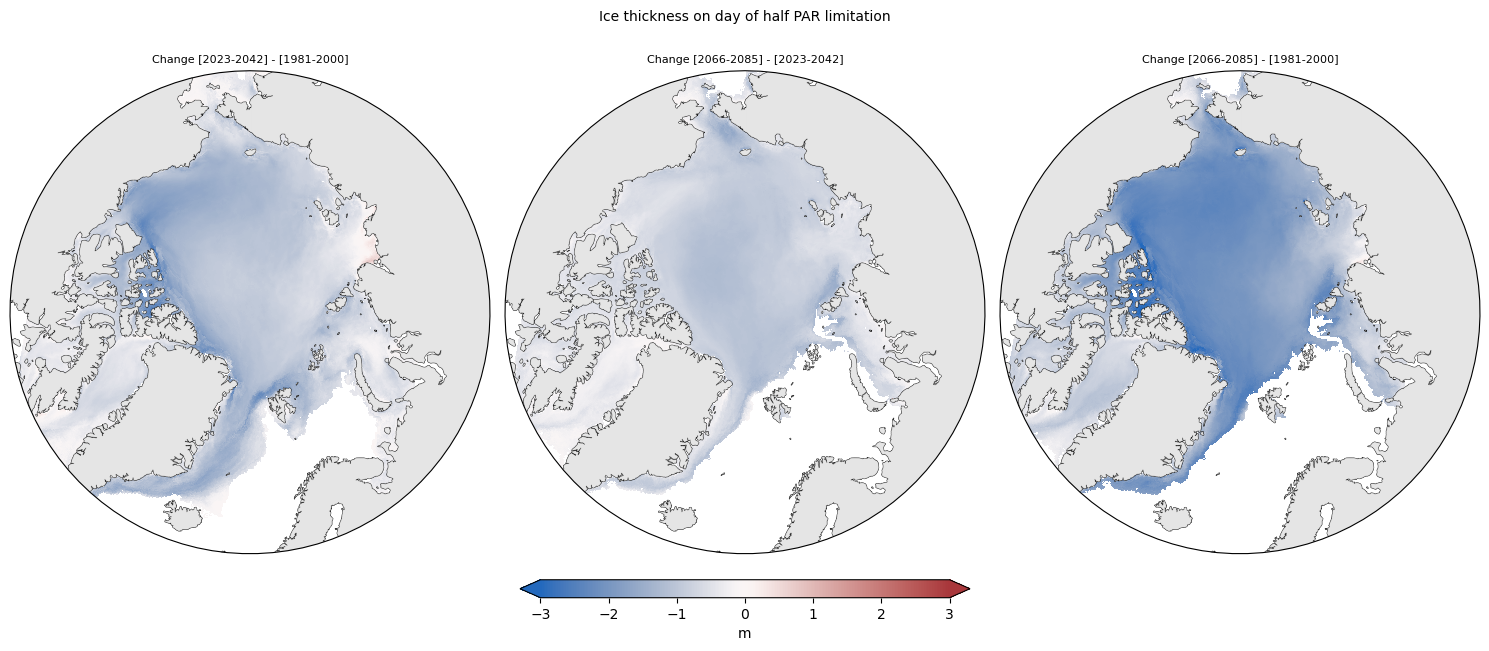

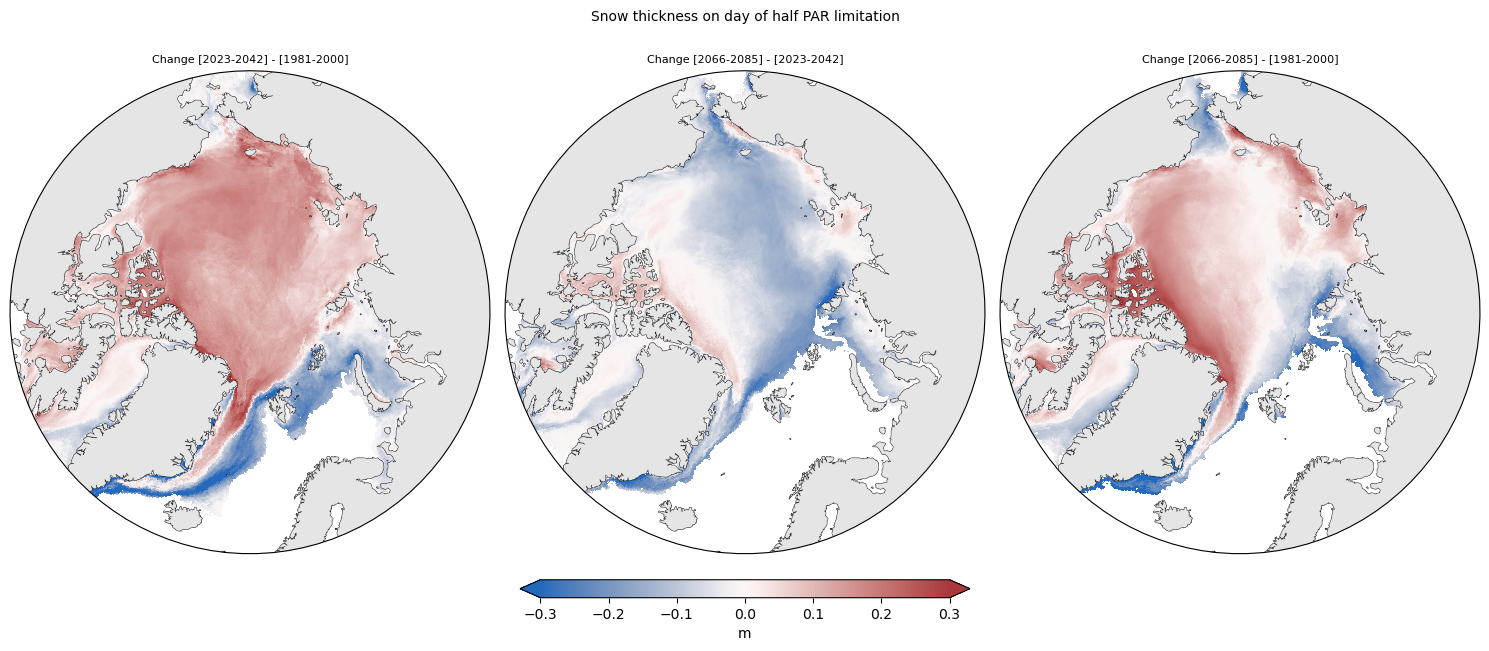

In [10]:
pltClimdiff({per:clim[per+'iicethic-halfPAR'] for per in periods},'Ice thickness on day of half PAR limitation','m',
                 diffpltkw={'vmin':-3, 'vmax':3, 'cmap':'vlag'},
)
pltClimdiff({per:clim[per+'isnowthi-halfPAR'] for per in periods},'Snow thickness on day of half PAR limitation','m',
                 diffpltkw={'vmin':-.3, 'vmax':.3, 'cmap':'vlag'},
)
            

# plt.savefig('../figs/IAphenology23/-300dpi.png',bbox_inches='tight',dpi=300)
# plt.savefig('../figs/IAphenology23/-90dpi.png',bbox_inches='tight',dpi=90)

### Spring means

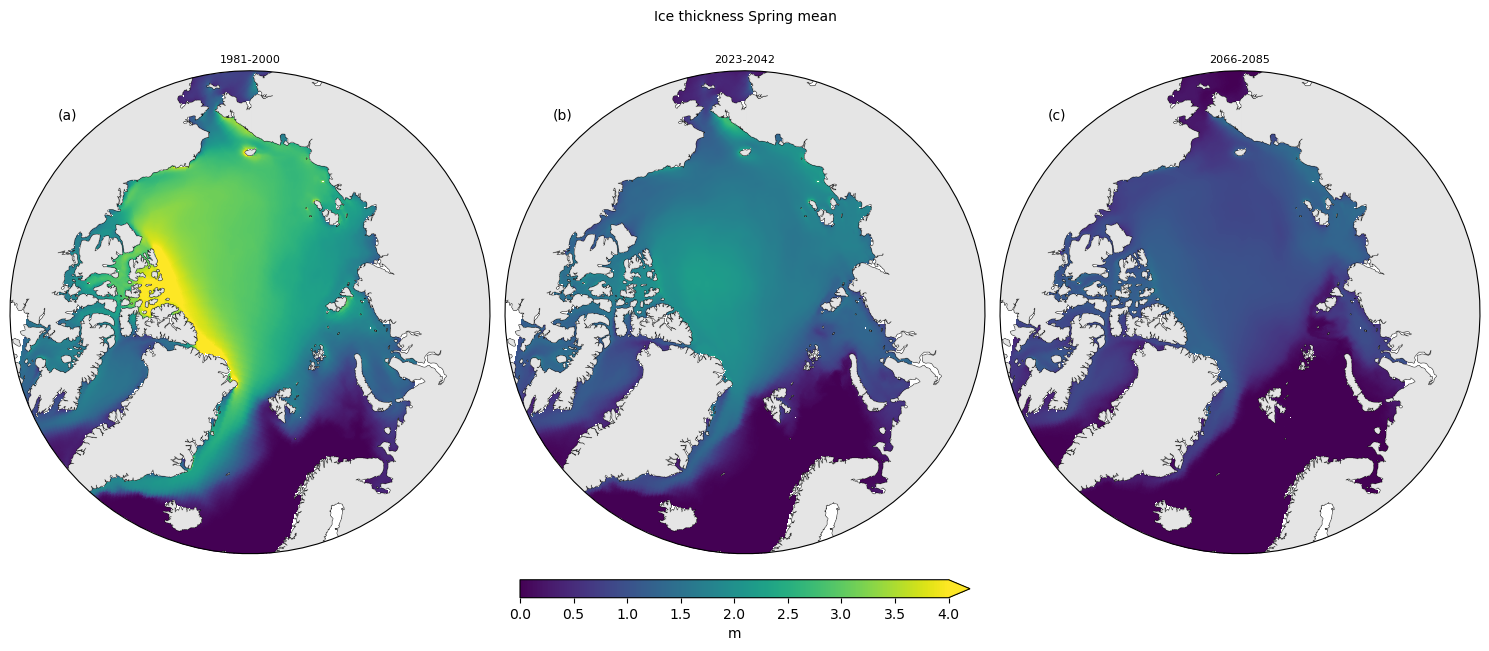

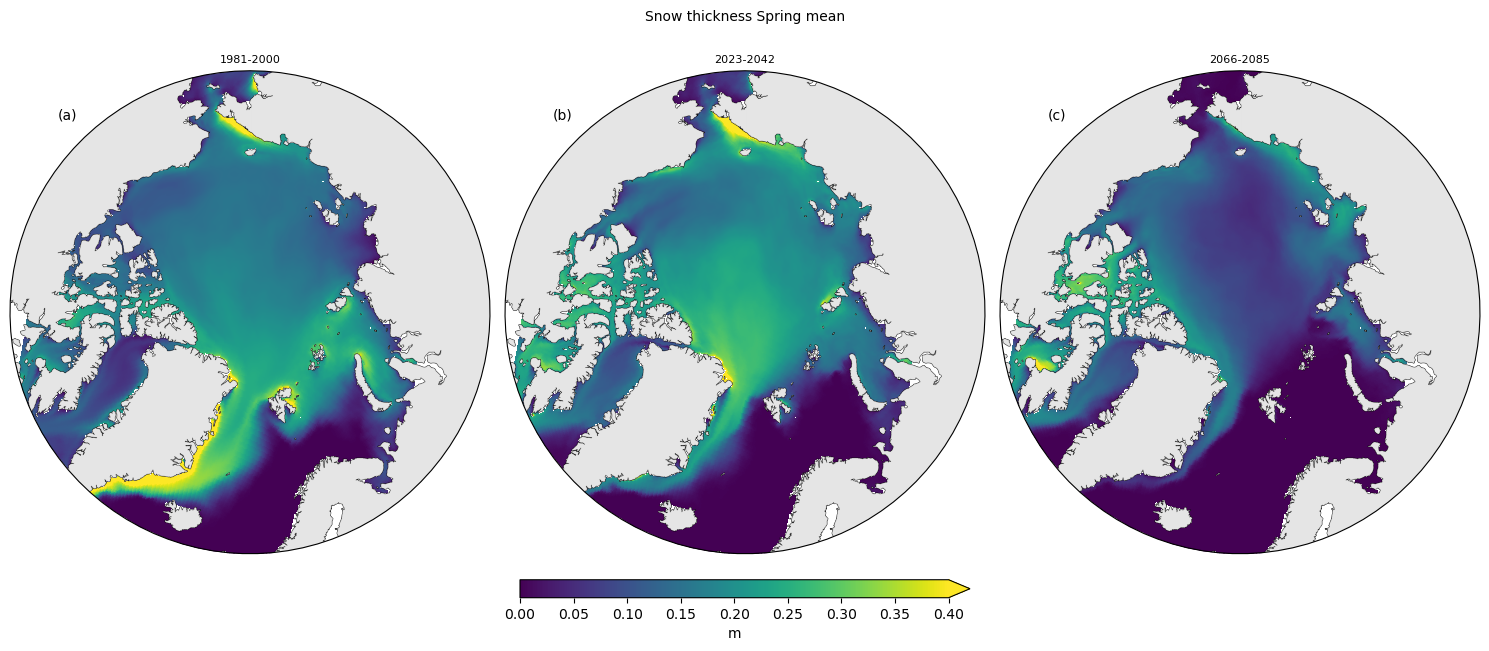

In [28]:
pltClim({per:clim[per+'iicethic'].sel(dayofyear=slice(31+28,31+28+31+30+31)).mean(dim='dayofyear') for per in periods},
        'Ice thickness Spring mean','m',
        vmin=0, vmax=4, cmap='viridis', extend='max')

pltClim({per:clim[per+'isnowthi'].sel(dayofyear=slice(31+28,31+28+31+30+31)).mean(dim='dayofyear') for per in periods},
        'Snow thickness Spring mean','m',
        vmin=0, vmax=.4, cmap='viridis', extend='max')
            

# plt.savefig('../figs/IAphenology23/-300dpi.png',bbox_inches='tight',dpi=300)
# plt.savefig('../figs/IAphenology23/-90dpi.png',bbox_inches='tight',dpi=90)

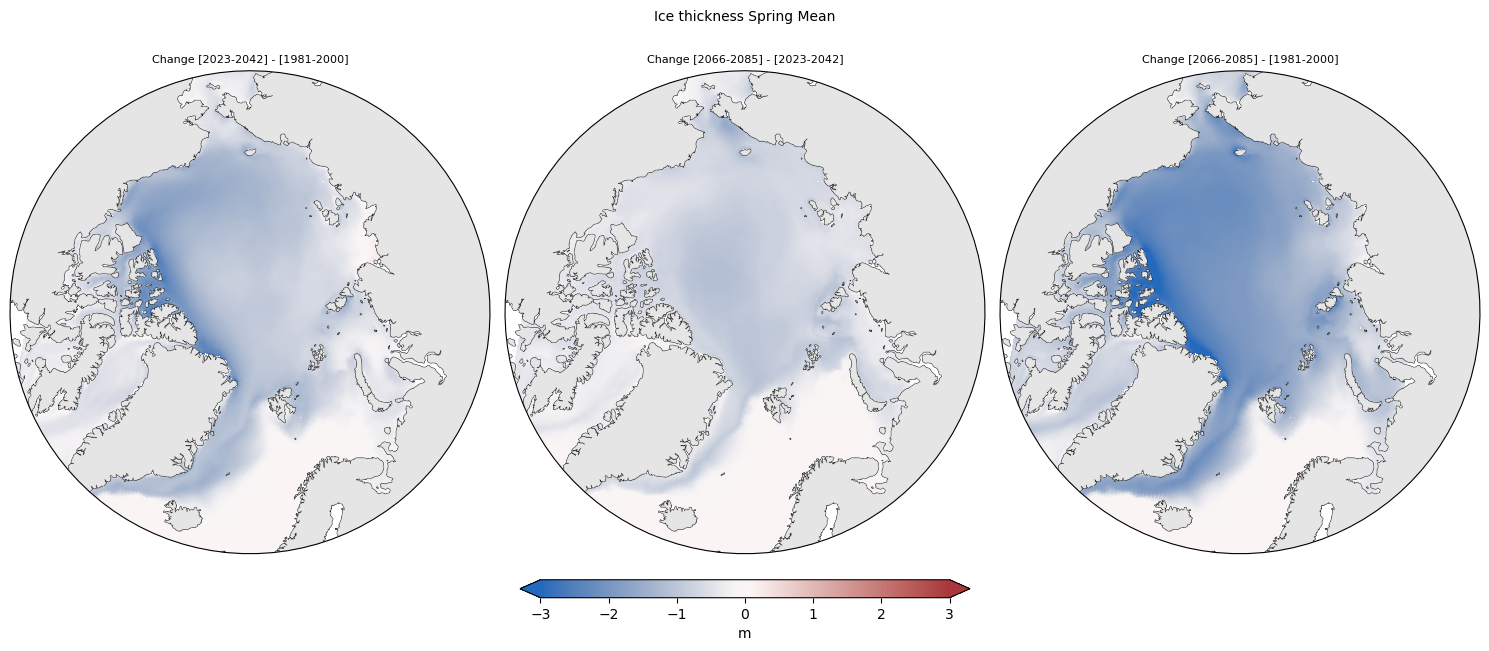

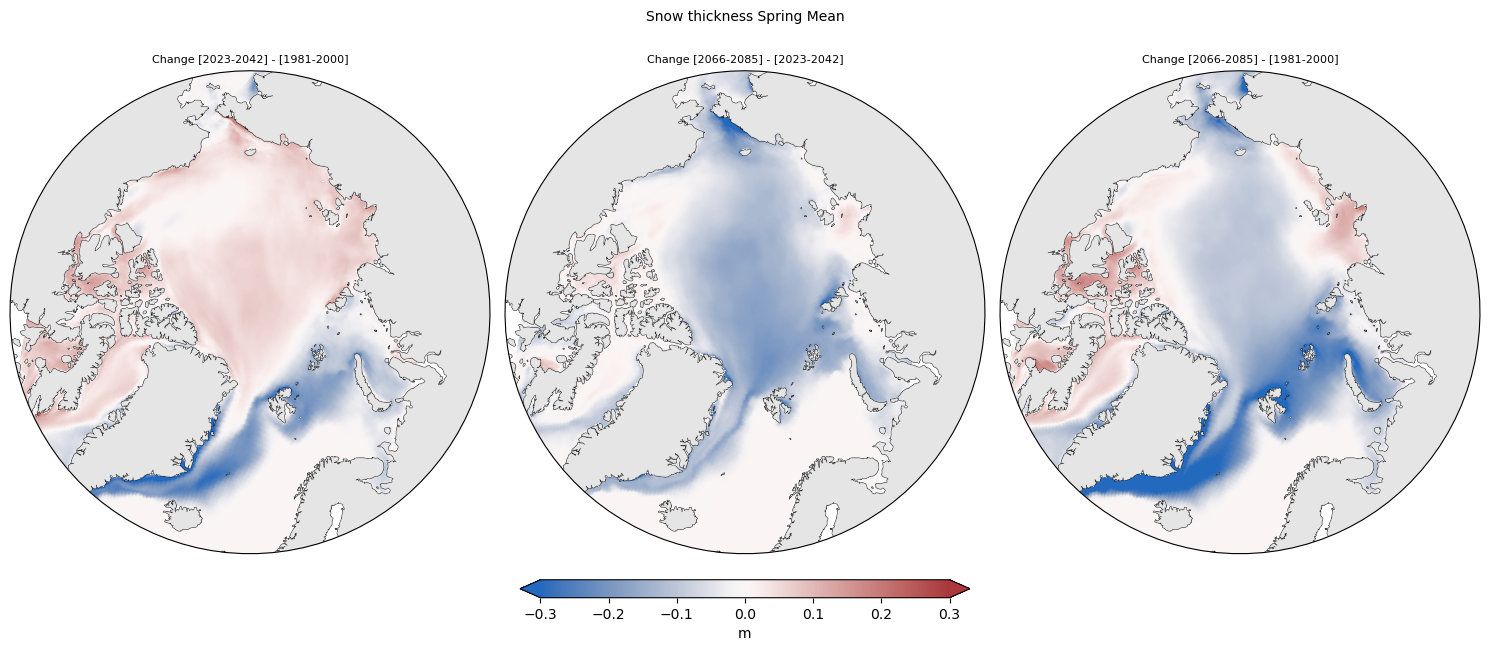

In [29]:
pltClimdiff({per:clim[per+'iicethic'].sel(dayofyear=slice(31+28,31+28+31+30+31)).mean(dim='dayofyear') for per in periods},
            'Ice thickness Spring Mean','m',
                 diffpltkw={'vmin':-3, 'vmax':3, 'cmap':'vlag'},
)
pltClimdiff({per:clim[per+'isnowthi'].sel(dayofyear=slice(31+28,31+28+31+30+31)).mean(dim='dayofyear') for per in periods},
            'Snow thickness Spring Mean','m',
                 diffpltkw={'vmin':-.3, 'vmax':.3, 'cmap':'vlag'},
)
            

# plt.savefig('../figs/IAphenology23/-300dpi.png',bbox_inches='tight',dpi=300)
# plt.savefig('../figs/IAphenology23/-90dpi.png',bbox_inches='tight',dpi=90)

### Monthly means

In [ ]:
pltClim({per:clim[per+'iicethic'].sel(dayofyear=slice(31+28,31+28+31)).mean(dim='dayofyear') for per in periods},
        'Ice thickness March mean','m',
        vmin=0, vmax=4, cmap='viridis', extend='max')

pltClim({per:clim[per+'isnowthi'].sel(dayofyear=slice(31+28,31+28+31)).mean(dim='dayofyear') for per in periods},
        'Snow thickness March mean','m',
        vmin=0, vmax=.4, cmap='viridis', extend='max')

In [ ]:
pltClimdiff({per:clim[per+'iicethic'].sel(dayofyear=slice(31+28,31+28+31)).mean(dim='dayofyear') for per in periods},
            'Ice thickness March Mean','m',
                 diffpltkw={'vmin':-3, 'vmax':3, 'cmap':'vlag'},
)
pltClimdiff({per:clim[per+'isnowthi'].sel(dayofyear=slice(31+28,31+28+31)).mean(dim='dayofyear') for per in periods},
            'Snow thickness March Mean','m',
                 diffpltkw={'vmin':-.3, 'vmax':.3, 'cmap':'vlag'},
)

In [ ]:
pltClimdiff({per:clim[per+'iicethic'].sel(dayofyear=slice(31+28+31,31+28+31+30)).mean(dim='dayofyear') for per in periods},
            'Ice thickness Change April Mean','m',
                 diffpltkw={'vmin':-3, 'vmax':3, 'cmap':'vlag'},
)
pltClimdiff({per:clim[per+'isnowthi'].sel(dayofyear=slice(31+28+31,31+28+31+30)).mean(dim='dayofyear') for per in periods},
            'Snow thickness Change April Mean','m',
                 diffpltkw={'vmin':-.3, 'vmax':.3, 'cmap':'vlag'},
)

In [ ]:
pltClimdiff({per:clim[per+'iicethic'].sel(dayofyear=slice(31+28+31,31+28+31+30)).mean(dim='dayofyear') for per in periods},
            'Ice thickness Change April Mean','m',
                 diffpltkw={'vmin':-3, 'vmax':3, 'cmap':'vlag'},
)
pltClimdiff({per:clim[per+'isnowthi'].sel(dayofyear=slice(31+28+31,31+28+31+30)).mean(dim='dayofyear') for per in periods},
            'Snow thickness Change April Mean','m',
                 diffpltkw={'vmin':-.3, 'vmax':.3, 'cmap':'vlag'},
)